In [706]:
import itertools
import json
import os
import re

import joblib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import tqdm

from evaluation import evaluate

In [707]:
def parse_log(logpath: str, *keys: str) -> list:
    log = []
    with open(logpath) as f:
        while (line := f.readline()):
            data = json.loads(line)
            logline = {}
            if 'all' in keys:
                logline = data
            else:
                for key in keys:
                    if ':' in key:
                        group, prop = key.split(':')
                        logline[prop] = data[group][prop]
                    else:
                        logline[key] = data[key]
            log.append(logline)
    return log

def save_parameter_stats(logpath: str, statspath: str):
    with open(statspath, 'w') as f:
        log = parse_log(
            logpath,
            'Parameters:SendTolerance',
            'Parameters:Transmission',
            'Statistics:Updates',
            'Statistics:Messages',
            'Statistics:RuntimeInSeconds')
        json.dump(log, f)

def save_reachability(logpath: str, reachpath: str):
    log = parse_log(logpath, 'Statistics:MessagesReachabilities')
    reaches = (np.array(run['MessagesReachabilities'], dtype=np.int8) for run in log)
    np.savez(
        reachpath, 
        **{f'r{r}': data for r, data in enumerate(reaches, start=1)})

def save_degrees(logpath: str, degpath: str):
    log = parse_log(logpath, 'Statistics:Degrees')
    degrees = (np.array(run['Degrees'], dtype=np.int16) for run in log)
    np.savez(
        degpath, 
        **{f'd{d}': data for d, data in enumerate(degrees, start=1)})

def save_symptoms(logpath: str, degpath: str):
    log = parse_log(logpath, 'SymptomScores')
    scores = (np.array(run['SymptomScores'], dtype=np.float64) for run in log)
    np.savez(
        degpath,
        **{f's{s}': data for s, data in enumerate(scores, start=1)})

def load_npz(path: str) -> list:
    with np.load(path) as data:
        arrs = list(data.values())
    return arrs

def load_data(datapath: str):
    with open(datapath) as f:
        return json.load(f)

def msg_reach(init, r0, alpha, gamma, eps=1e-7):
    num = np.log(np.maximum(eps, gamma * alpha * r0) / np.maximum(eps, init))
    den = np.log(alpha)
    return np.maximum(0, num / den)

def compare_reaches(symptoms, reaches, alpha, gamma, n=100_000):
    reaches = reaches[reaches != 0].astype(np.int64)
    symptoms = symptoms.astype(np.float64)
    inits = alpha * symptoms
    r0 = symptoms.mean()
    expected = np.array([
        msg_reach(init=i, alpha=alpha, gamma=gamma, r0=r0)
        for i in inits])
    expected = (expected.mean(), sp.stats.sem(expected))
    actual = (reaches.mean(), sp.stats.sem(reaches))
    return expected, actual

## Parameter Experiments

In [708]:
def save_tolerance_data(df: pd.DataFrame, y: str, label: str = None):
    df2 = df.copy()
    df2.loc[:, 'SendTolerance'] *= 10
    df2.loc[:, 'SendTolerance'] = df2.SendTolerance.astype(int)
    df_save = df2[['SendTolerance', y]]
    df_save.index = df_save[y]
    df_save = df_save.drop(columns=y)
    df_save.to_csv(f'figures//tolerance-{(label or y).lower()}.csv')

## Preprocessing

In [709]:
graphs = ('lfr', 'power', 'geometric')
lognames = ('lfr-1642133470', 'power-1642133471', 'geometric-1642133470')
logpaths = {name.split('-')[0]: os.path.join(evaluate.PARAMS_DIR, f'{name}.log') for name in lognames}
statpaths = {graph: os.path.join(evaluate.PARAMS_DIR, f'{graph}-stat.json') for graph in graphs}
reachpaths = {graph: os.path.join(evaluate.PARAMS_DIR, f'{graph}-reach.npz') for graph in graphs}
degpaths = {graph: os.path.join(evaluate.PARAMS_DIR, f'{graph}-deg.npz') for graph in graphs}
sympaths = {graph: os.path.join(evaluate.PARAMS_DIR, f'{graph}-sym.npz') for graph in graphs}

In [710]:
# par = joblib.Parallel(n_jobs=len(graphs))
# par(joblib.delayed(save_parameter_stats)(logpaths[g], statpaths[g]) for g in graphs)
# par(joblib.delayed(save_reachability)(logpaths[g], reachpaths[g]) for g in graphs)
# par(joblib.delayed(save_degrees)(logpaths[g], degpaths[g]) for g in graphs)
# par(joblib.delayed(save_symptoms)(logpaths[g], sympaths[g]) for g in graphs)

In [711]:
dfs = []
for graph, statpath in statpaths.items():
    stats = load_data(statpath)
    df = pd.DataFrame(stats)
    df['Graph'] = len(stats) * [graph]
    dfs.append(df)
df = pd.concat(dfs)

analyze = ('Updates', 'RuntimeInSeconds', 'Messages')

for stat in analyze:
    df[f'Normalized{stat}'] = df[stat] / df.groupby(['Graph', 'Transmission'])[stat].transform('max')

In [712]:
save_tolerance_data(df[df['Transmission'] > 0.3], 'NormalizedUpdates', 'updates')
save_tolerance_data(df, 'NormalizedRuntimeInSeconds', 'runtime')
save_tolerance_data(df, 'NormalizedMessages', 'messages')

## Analysis

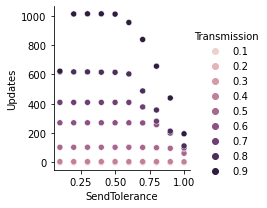

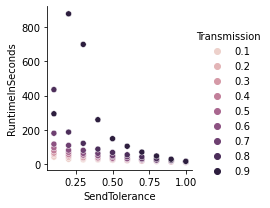

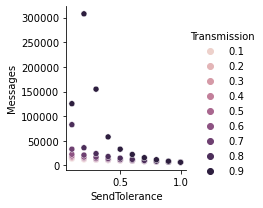

In [713]:
data = df.loc[(df['Graph'] == 'power')]
for stat in analyze:
    sns.relplot(data=data, x='SendTolerance', y=stat, hue='Transmission', legend='full', height=3);

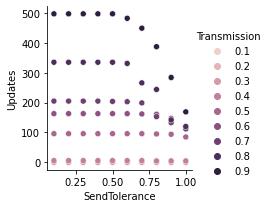

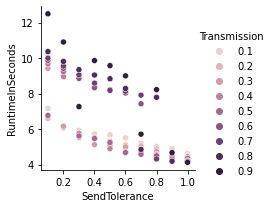

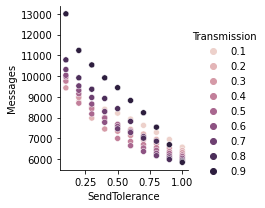

In [714]:
data = df.loc[(df['Graph'] == 'lfr')]
for stat in analyze:
    sns.relplot(data=data, x='SendTolerance', y=stat, hue='Transmission', legend='full', height=3);

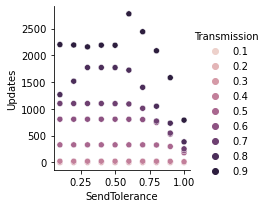

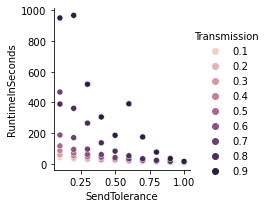

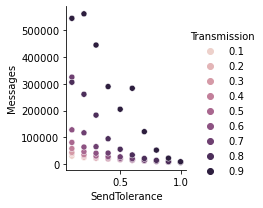

In [715]:
data = df.loc[(df['Graph'] == 'geometric')]
for stat in analyze:
    sns.relplot(data=data, x='SendTolerance', y=stat, hue='Transmission', legend='full', height=3);

In [716]:
df.groupby('SendTolerance')['NormalizedMessages'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,27.0,0.976931,0.114022,0.407127,1.000000,1.000000,1.000000,1.000000
0.2,27.0,0.792070,0.173117,0.360168,0.698015,0.852839,0.919175,1.000000
0.3,27.0,0.667564,0.205999,0.200947,0.516139,0.744900,0.841631,0.900678
0.4,27.0,0.577064,0.237012,0.127247,0.382841,0.643892,0.795796,0.852652
0.5,27.0,0.521403,0.249592,0.083775,0.321494,0.576412,0.740798,0.833283
0.6,27.0,0.484259,0.247898,0.062992,0.285484,0.540627,0.704322,0.804584
0.7,27.0,0.434455,0.247479,0.044707,0.218348,0.489732,0.653806,0.773755
0.8,27.0,0.395784,0.246374,0.032674,0.156983,0.407149,0.623684,0.739783
0.9,27.0,0.361084,0.241661,0.026630,0.127976,0.364391,0.573125,0.705202


In [717]:
df[df['Transmission'] == 0.8].groupby('SendTolerance')['NormalizedMessages'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.2,3.0,0.735166,0.264077,0.432708,0.642773,0.852839,0.886395,0.919952
0.3,3.0,0.585251,0.290363,0.288641,0.443408,0.598175,0.733556,0.868936
0.4,3.0,0.451462,0.329086,0.216953,0.263363,0.309772,0.568716,0.827660
0.5,3.0,0.380497,0.348059,0.177619,0.179548,0.181478,0.481936,0.782395
0.6,3.0,0.328166,0.344488,0.112195,0.129528,0.146861,0.436152,0.725443
0.7,3.0,0.280119,0.321944,0.069145,0.094837,0.120529,0.385606,0.650682
0.8,3.0,0.261817,0.326157,0.046271,0.074202,0.102132,0.369590,0.637047
0.9,3.0,0.223059,0.289258,0.030612,0.056739,0.082865,0.319282,0.555700


In [718]:
df.groupby('SendTolerance')['NormalizedRuntimeInSeconds'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,27.0,0.954478,0.143593,0.334744,1.000000,1.000000,1.000000,1.000000
0.2,27.0,0.761621,0.182443,0.363107,0.655889,0.726222,0.937655,1.000000
0.3,27.0,0.587418,0.177284,0.203040,0.522837,0.587717,0.648022,0.905787
0.4,27.0,0.496281,0.208412,0.126369,0.331330,0.480395,0.598242,0.872443
0.5,27.0,0.441393,0.230038,0.085580,0.249739,0.414378,0.580090,0.852423
0.6,27.0,0.405706,0.231071,0.067475,0.231222,0.369347,0.522420,0.813844
0.7,27.0,0.340996,0.212528,0.047921,0.175928,0.304318,0.475506,0.791524
0.8,27.0,0.305561,0.211061,0.036562,0.122483,0.260689,0.464477,0.751396
0.9,27.0,0.254742,0.182567,0.029741,0.100008,0.199819,0.413859,0.682348


In [719]:
df[df['Transmission'] == 0.8].groupby('SendTolerance')['NormalizedRuntimeInSeconds'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.2,3.0,0.768258,0.293535,0.429466,0.679149,0.928832,0.937655,0.946478
0.3,3.0,0.620060,0.316001,0.278307,0.479258,0.680209,0.790936,0.901664
0.4,3.0,0.474165,0.352780,0.200970,0.275026,0.349082,0.610762,0.872443
0.5,3.0,0.406039,0.387505,0.156079,0.182847,0.209616,0.531019,0.852423
0.6,3.0,0.351912,0.387489,0.124524,0.128205,0.131886,0.465605,0.799325
0.7,3.0,0.216092,0.218744,0.081925,0.089884,0.097843,0.283176,0.468509
0.8,3.0,0.292604,0.397391,0.055983,0.063207,0.070432,0.410914,0.751396
0.9,3.0,0.164827,0.207589,0.039524,0.045017,0.050510,0.227478,0.404446


In [720]:
df.groupby('SendTolerance')['NormalizedUpdates'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,18.0,0.951180,0.116468,0.614018,1.000000,1.000000,1.000000,1.000000
0.2,18.0,0.980269,0.058340,0.790137,1.000000,1.000000,1.000000,1.000000
0.3,18.0,0.987641,0.052435,0.777538,1.000000,1.000000,1.000000,1.000000
0.4,18.0,0.988101,0.049681,0.789057,1.000000,1.000000,1.000000,1.000000
0.5,18.0,0.987458,0.049720,0.788337,0.998497,1.000000,1.000000,1.000000
0.6,18.0,0.990564,0.015875,0.941757,0.988606,1.000000,1.000000,1.000000
0.7,18.0,0.931694,0.081806,0.789303,0.885412,0.980511,0.999074,1.000000
0.8,18.0,0.825651,0.152175,0.578606,0.708656,0.806003,0.983516,1.000000
0.9,18.0,0.680692,0.222353,0.345219,0.491181,0.651528,0.904576,1.000000


In [721]:
df[df['Transmission'] == 0.8].groupby('SendTolerance')['NormalizedUpdates'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,3.0,0.904735,0.165004,0.714205,0.857103,1.000000,1.000000,1.000000
0.2,3.0,0.951898,0.083315,0.855693,0.927847,1.000000,1.000000,1.000000
0.3,3.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.4,3.0,0.998920,0.001871,0.996759,0.998379,1.000000,1.000000,1.000000
0.5,3.0,0.998191,0.002659,0.995138,0.997287,0.999436,0.999718,1.000000
0.6,3.0,0.979249,0.008018,0.972379,0.974844,0.977310,0.982685,0.988060
0.7,3.0,0.791400,0.002408,0.789303,0.790086,0.790868,0.792449,0.794030
0.8,3.0,0.632949,0.082893,0.578606,0.585244,0.591883,0.660120,0.728358
0.9,3.0,0.394097,0.042666,0.345219,0.379205,0.413191,0.418536,0.423881


In [722]:
nupdates = df[(df['Transmission'] > 0.3) & (df['SendTolerance'] == 0.6)]['NormalizedUpdates']

In [723]:
nupdates.mean()

0.9905641387465138

In [724]:
nupdates.std() / len(nupdates)

0.0008819565056807425

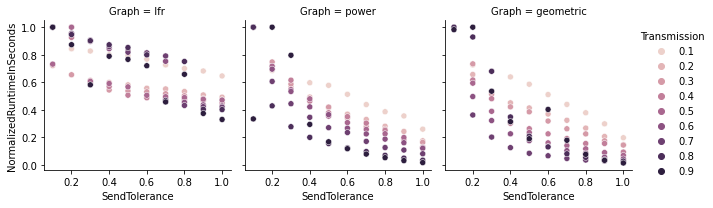

In [725]:
sns.relplot(
    data=df, 
    x='SendTolerance',
    y='NormalizedRuntimeInSeconds',
    hue='Transmission',
    col='Graph',
    height=3,
    legend='full');

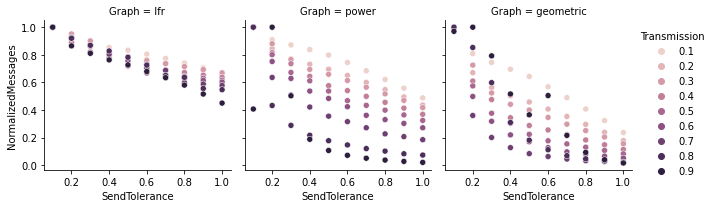

In [726]:
sns.relplot(
    data=df, 
    x='SendTolerance',
    y='NormalizedMessages',
    hue='Transmission',
    col='Graph',
    height=3,
    legend='full');

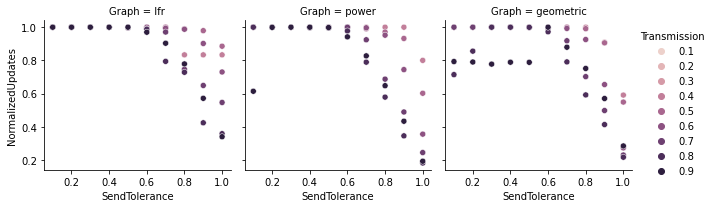

In [727]:
sns.relplot(
    data=df, 
    x='SendTolerance',
    y='NormalizedUpdates',
    hue='Transmission',
    col='Graph',
    height=3,
    legend='full');

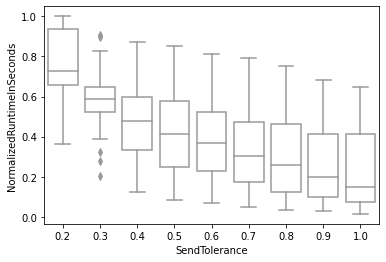

In [728]:
sns.boxplot(
    data=df[df['SendTolerance'] > 0.1],
    x='SendTolerance',
    y='NormalizedRuntimeInSeconds',
    color='white');

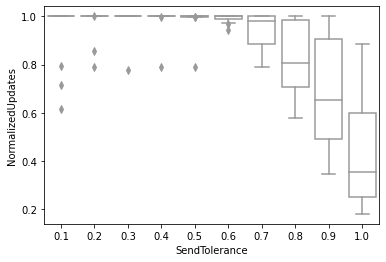

In [729]:
sns.boxplot(
    data=df,
    x='SendTolerance',
    y='NormalizedUpdates',
    color='white');

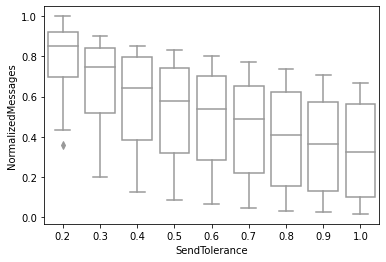

In [730]:
sns.boxplot(
    data=df[df['SendTolerance'] > 0.1],
    x='SendTolerance',
    y='NormalizedMessages',
    color='white');

In [731]:
def save_ratio_data(df: pd.DataFrame, tolerance_or_transmission: str, label: str = None):
    df2 = df.copy()
    df2.loc[:, tolerance_or_transmission] *= 10
    df2.loc[:, tolerance_or_transmission] = df2[tolerance_or_transmission].astype(int)
    df_save = df2[[tolerance_or_transmission, 'RatioValue']]
    df_save.index = df_save.RatioValue
    df_save = df_save.drop(columns='RatioValue')
    df_save.to_csv(f'figures//ratio-{(label or tolerance_or_transmission).lower()}.csv')
    
def compare_all_reaches(graph: str, reachpaths: dict, sympaths: dict):
    reaches = load_npz(reachpaths[graph])
    symptoms = load_npz(sympaths[graph])
    gammas = np.arange(0.1, 1.1, 0.1)
    alphas = np.arange(0.1, 1, 0.1)
    loop = list(enumerate((itertools.product(gammas, alphas))))
    records = []
    for i, (gamma, alpha) in tqdm.tqdm(loop):
        expected, actual = compare_reaches(
            symptoms=symptoms[i], 
            reaches=reaches[i], 
            alpha=alpha, 
            gamma=gamma, 
            n=1000)
        records.append({
            'Graph': graph,
            'Transmission': alpha,
            'SendTolerance': gamma,
            'ExpectedValue': expected[0],
            'ExpectedStdErr': expected[1],
            'ActualValue': actual[0],
            'ActualStdErr': actual[1]})
    return records

def div_stderr(numval, numerr, denval, denerr):
    return np.abs(numval / denval) * np.linalg.norm([numerr / numval, denerr / denval])

def add_stderr(errs, average=True):
    stderr = np.linalg.norm(errs)
    if average:
        stderr /= len(errs)
    return stderr

In [756]:
reaches = [compare_all_reaches(g, reachpaths, sympaths) for g in graphs]
reaches = pd.concat([pd.DataFrame(r) for r in reaches])
reaches['RatioValue'] = reaches.ActualValue / reaches.ExpectedValue
reaches['RatioStdErr'] = 1.96 * div_stderr(
    reaches.ActualValue, reaches.ActualStdErr, reaches.ExpectedValue, reaches.ExpectedStdErr)

100%|███████████████████████████████████████████| 90/90 [00:02<00:00, 38.23it/s]


In [757]:
save_ratio_data(reaches, 'Transmission', label='transmission')
save_ratio_data(reaches, 'SendTolerance', label='tolerance')

In [758]:
reaches.groupby('Graph')['ExpectedValue'].describe()

,count,mean,std,min,25%,50%,75%,max
Graph,,,,,,,,
geometric,90.0,1.971345,3.283482,0.046960,0.290184,0.849300,2.013868,21.370391
lfr,90.0,1.971867,3.286367,0.045951,0.289094,0.849792,2.017983,21.381097
power,90.0,1.971937,3.287250,0.045533,0.288558,0.850721,2.019051,21.384189


In [759]:
reaches.groupby('Graph')['ActualValue'].describe()

,count,mean,std,min,25%,50%,75%,max
Graph,,,,,,,,
geometric,90.0,1.726149,0.695810,1.0,1.181730,1.532784,2.166239,3.285371
lfr,90.0,2.007048,0.993219,1.0,1.269741,1.735897,2.566260,4.475418
power,90.0,2.105625,0.769905,1.0,1.645683,2.157902,2.740100,3.333299


In [760]:
reaches.groupby('Graph')['RatioValue'].describe()

,count,mean,std,min,25%,50%,75%,max
Graph,,,,,,,,
geometric,90.0,3.333310,3.892828,0.153735,0.977914,1.758246,3.965374,21.294862
lfr,90.0,3.564584,3.951440,0.209317,1.096418,1.966581,4.373145,21.762380
power,90.0,3.966684,4.121833,0.155877,1.228125,2.406134,5.142422,21.962120


In [761]:
reaches.groupby(['SendTolerance'])['RatioValue'].describe()

,count,mean,std,min,25%,50%,75%,max
SendTolerance,,,,,,,,
0.1,27.0,0.851720,0.455834,0.153735,0.509757,0.882900,1.111260,1.907137
0.2,27.0,1.075654,0.558785,0.221801,0.680981,1.020279,1.430411,2.429207
0.3,27.0,1.261520,0.589654,0.291330,0.854195,1.186205,1.722760,2.383061
0.4,27.0,1.558441,0.755533,0.367268,1.001456,1.510020,2.105894,3.055795
0.5,27.0,1.918060,0.924725,0.476312,1.225160,1.793204,2.521127,3.585554
0.6,27.0,2.549698,1.307680,0.638516,1.556357,2.430844,3.444284,5.004830
0.7,27.0,3.600961,1.906561,0.879842,2.182155,3.628261,4.600539,7.481665
0.8,27.0,5.746904,3.225588,1.302187,3.293661,5.178244,7.417738,12.367480
0.9,27.0,8.111482,4.732559,1.694711,4.875131,7.317126,9.741000,18.363566


In [762]:
reaches.groupby(['Transmission'])['RatioValue'].describe()

,count,mean,std,min,25%,50%,75%,max
Transmission,,,,,,,,
0.1,30.0,7.656022,7.015926,1.511212,2.159098,4.287318,12.354624,21.962120
0.2,30.0,5.525983,4.775732,1.136173,1.993523,3.275348,8.635511,15.350863
0.3,30.0,4.399866,3.490374,0.960866,1.686694,3.134410,6.528246,11.483526
0.4,30.0,3.789709,2.886491,0.882900,1.515237,2.455649,6.138366,9.226070
0.5,30.0,3.406941,2.886375,0.783632,1.229206,2.016690,4.826937,10.880034
0.6,30.0,2.773995,2.209247,0.643276,1.087815,1.815408,3.887377,8.600039
0.7,30.0,2.328739,1.947252,0.495658,0.921960,1.451283,3.320412,7.340695
0.8,30.0,1.751322,1.505474,0.324325,0.634573,1.075712,2.712338,5.744868
0.9,30.0,0.961155,0.825934,0.153735,0.318511,0.631581,1.506371,2.931254


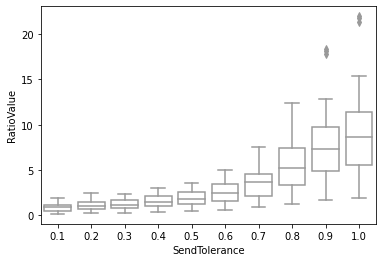

In [739]:
sns.boxplot(
    data=reaches,
    x=reaches.SendTolerance.round(2),
    y=reaches.RatioValue,
    color='white');

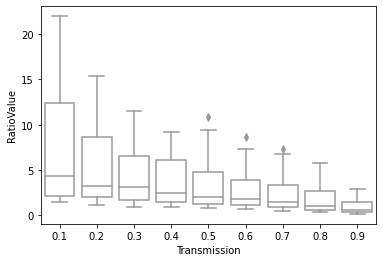

In [740]:
sns.boxplot(
    data=reaches,
    x=reaches.Transmission.round(2),
    y='RatioValue',
    color='white');

In [741]:
data = reaches[['Transmission', 'RatioValue']].copy()
data.index = data.RatioValue

In [742]:
select = reaches[(reaches['Transmission'] == 0.8) & (reaches['SendTolerance'] == 0.6)]
select[['Graph', 'RatioValue', 'RatioStdErr']]

,Graph,RatioValue,RatioStdErr
52,lfr,1.312642,0.663802
52,power,1.341327,0.678308
52,geometric,1.106261,0.559435


In [743]:
ratios = select.RatioValue.values
errs = select.RatioStdErr.values
# Already includes 1.96 factor
print(f'({round(ratios.mean(), 3)} +/- {round(add_stderr(errs), 3)})x actual reachability')

(1.253 +/- 0.367)x actual reachability


## Scalability Experiments

In [744]:
graphs = ('lfr', 'power', 'geometric')
lognames = ('lfr-1642133470', 'power-1642133471', 'geometric-1642133470')
logpaths = {name.split('-')[0]: os.path.join(evaluate.PARAMS_DIR, f'{name}.log') for name in lognames}
statpaths = {graph: os.path.join(evaluate.PARAMS_DIR, f'{graph}-stat.json') for graph in graphs}
reachpaths = {graph: os.path.join(evaluate.PARAMS_DIR, f'{graph}-reach.npz') for graph in graphs}
degpaths = {graph: os.path.join(evaluate.PARAMS_DIR, f'{graph}-deg.npz') for graph in graphs}
sympaths = {graph: os.path.join(evaluate.PARAMS_DIR, f'{graph}-sym.npz') for graph in graphs}

## Real-World Experiments

In [745]:
settings = ('workplace', 'highschool12', 'conference')
lognames = ('workplace-1642112756', 'highschool12-1642112756', 'conference-1642112759')
logpaths = {name.split('-')[0]: os.path.join(evaluate.REAL_WORLD_DIR, f'{name}.log') for name in lognames}

In [746]:
logs = {}

for setting, logpath in logpaths.items():
    log = parse_log(logpath, 'all')
    logs[setting] = {
        'stats': pd.DataFrame([run['Statistics'] for run in log]),
        'params': pd.DataFrame([run['Parameters'] for run in log]),
        'symptoms': pd.DataFrame([run['SymptomScores'] for run in log]),
        'exposures': pd.DataFrame([run['SymptomScores'] for run in log])}

for setting, log in logs.items():
    log['stats']['Setting'] = len(log['stats']) * [setting]

stats = pd.concat([logs[s]['stats'] for s in settings])
params = pd.concat([logs[s]['params'] for s in settings])

df = pd.concat([stats, params], axis=1)

conference = df.loc[df['Setting'] == 'conference']
workplace = df.loc[df['Setting'] == 'workplace']
school = df.loc[df['Setting'] == 'highschool12']

c_reaches = np.array([r for r in conference.MessagesReachabilities.values], dtype=np.int8)
c_reaches = c_reaches[c_reaches != 0]
w_reaches = np.array([r for r in workplace.MessagesReachabilities.values], dtype=np.int8)
w_reaches = w_reaches[w_reaches != 0]
s_reaches = np.array([r for r in school.MessagesReachabilities.values], dtype=np.int8)
s_reaches = s_reaches[s_reaches != 0]
reaches = (c_reaches, w_reaches, s_reaches)

In [747]:
df.groupby('Setting')[['Radius']].describe()

Radius                                   
              count mean  std  min  25%  50%  75%  max
Setting                                               
conference     10.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
highschool12   10.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0
workplace      10.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0

In [748]:
df.groupby('Setting')[['Diameter']].describe()

Diameter                                   
                count mean  std  min  25%  50%  75%  max
Setting                                                 
conference       10.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0
highschool12     10.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0
workplace        10.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0

In [749]:
conference[[
    'MinDegree', 
    'MaxDegree', 
    'AvgDegree', 
    'StdDegree',
    'MinEfficiency',
    'MaxEfficiency',
    'AvgEfficiency',
    'StdEfficiency',
    'MinMessageReachability',
    'MaxMessageReachability',
    'AvgMessageReachability',
    'StdMessageReachability']].describe()

,MinDegree,MaxDegree,AvgDegree,StdDegree,MinEfficiency,MaxEfficiency,AvgEfficiency,StdEfficiency,MinMessageReachability,MaxMessageReachability,AvgMessageReachability,StdMessageReachability
count,10.0,10.0,10.000,1.000000e+01,10.000,1.000000e+01,10.0000,1.000000e+01,10.0,10.000000,10.000000,10.000000
mean,1.0,169.0,47.469,3.014340e+01,0.391,7.098000e-01,0.5472,4.960000e-02,0.0,5.400000,1.169950,1.061070
std,0.0,0.0,0.000,3.744889e-15,0.000,1.170278e-16,0.0000,7.314236e-18,0.0,0.516398,0.028291,0.004925
min,1.0,169.0,47.469,3.014340e+01,0.391,7.098000e-01,0.5472,4.960000e-02,0.0,5.000000,1.137700,1.054000
25%,1.0,169.0,47.469,3.014340e+01,0.391,7.098000e-01,0.5472,4.960000e-02,0.0,5.000000,1.144775,1.057075
50%,1.0,169.0,47.469,3.014340e+01,0.391,7.098000e-01,0.5472,4.960000e-02,0.0,5.000000,1.162650,1.062350
75%,1.0,169.0,47.469,3.014340e+01,0.391,7.098000e-01,0.5472,4.960000e-02,0.0,6.000000,1.195800,1.063700
max,1.0,169.0,47.469,3.014340e+01,0.391,7.098000e-01,0.5472,4.960000e-02,0.0,6.000000,1.213300,1.069500


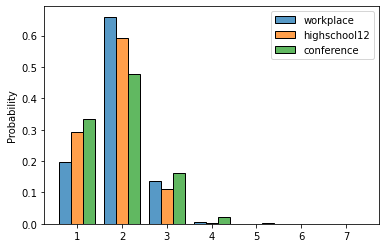

In [750]:
sns.histplot(
    data={s: r for s, r in zip(settings, reaches)},
    multiple='dodge',
    stat='probability',
    shrink=0.8,
    discrete=True,
    common_norm=False,
    common_bins=True);

In [751]:
df.groupby('Setting')[['RuntimeInSeconds']].describe()

RuntimeInSeconds                                          \
                        count      mean       std      min        25%   
Setting                                                                 
conference               10.0  20.65007  5.833157  14.1681  16.005500   
highschool12             10.0   2.30868  0.590946   1.4308   2.061325   
workplace                10.0   6.79757  1.787191   4.7251   5.440650   

                                            
                   50%        75%      max  
Setting                                     
conference    20.10785  23.884750  32.4736  
highschool12   2.36135   2.736450   3.1840  
workplace      6.81990   7.207975  10.7996

In [752]:
df.groupby('Setting')[['Messages']].describe()

Messages                                                         \
                count    mean          std     min      25%     50%      75%   
Setting                                                                        
conference       10.0  6223.2  1790.445990  4259.0  4748.00  6110.5  7040.00   
highschool12     10.0  2741.9   641.119065  1712.0  2580.00  2675.0  3183.25   
workplace        10.0  2833.0   690.842481  2000.0  2292.75  2834.0  2982.75   

                      
                 max  
Setting               
conference    9887.0  
highschool12  3597.0  
workplace     4352.0

In [753]:
df.groupby('Setting')[['ReachabilityRatio']].describe()

ReachabilityRatio                                                \
                         count     mean       std     min       25%      50%   
Setting                                                                        
conference                10.0  0.39180  0.006335  0.3845  0.387050  0.39030   
highschool12              10.0  0.28772  0.009545  0.2762  0.279675  0.28750   
workplace                 10.0  0.39682  0.007710  0.3878  0.392525  0.39565   

                                
                   75%     max  
Setting                         
conference    0.395675  0.4042  
highschool12  0.292750  0.3068  
workplace     0.397900  0.4118

In [754]:
ratios = []
for reach, setting in zip(reaches, settings):
    (expval, experr), (actval, acterr) = compare_reaches(
        symptoms=logs[setting]['symptoms'].to_numpy().flatten(), 
        reaches=reach, 
        alpha=0.8,
        gamma=0.6)
    ratval = actval / expval
    raterr = div_stderr(actval, acterr, expval, experr)
    ratios.append((ratval, raterr))
    print(f'{setting}:\t {round(ratval, 3)} +/- {round(raterr, 3)} x actual reachability')
mean = round(np.mean([r[0] for r in ratios]), 3)
err = round(1.96 * add_stderr([r[1] for r in ratios]), 3)
print(f'overall:\t ({mean} +/- {err})x actual reachability')

workplace:	 0.921 +/- 0.022 x actual reachability
highschool12:	 0.843 +/- 0.02 x actual reachability
conference:	 0.884 +/- 0.015 x actual reachability
overall:	 (0.883 +/- 0.022)x actual reachability
